            Births
Date              
1959-01-01      35
1959-01-02      32
1959-01-03      30
1959-01-04      31
1959-01-05      44


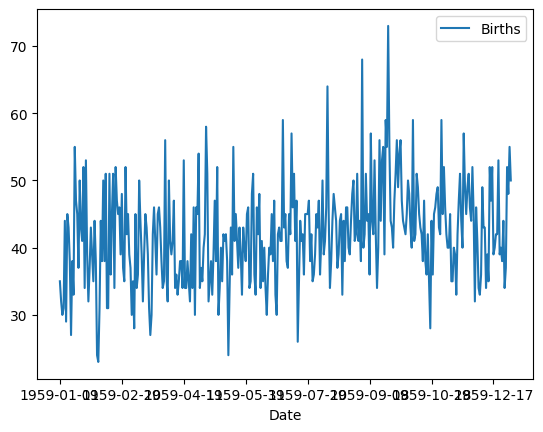

<Figure size 640x480 with 0 Axes>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

series = pd.read_csv('daily-total-female-births.csv', header=0, index_col=0)
print(series.head())
series.plot()
plt.show()
plt.tight_layout()

In [3]:
# fit and evaluate an AR model
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import numpy
from math import sqrt
 
# create a difference transform of the dataset
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
        
    return numpy.array(diff)
 
# Make a prediction give regression coefficients and lag obs
def predict(coef, history):
    yhat = coef[0]
    for i in range(1, len(coef)):
        yhat += coef[i] * history[-i]
        
    return yhat

In [5]:
series = pd.read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True)

# split dataset
X = difference(series.values)
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:]

In [11]:
size, train.shape, test.shape

(240, (240, 1), (124, 1))

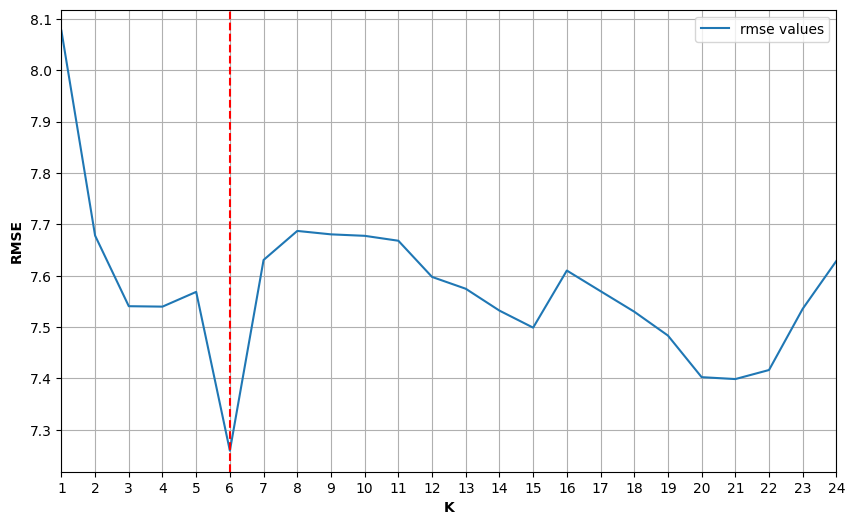

In [49]:
import numpy as np

# train autoregression
rmse_list = []
window_list = []
for i in range(1, 25):
    window = i
    model = AutoReg(train, lags=window)
    model_fit = model.fit()
    coef = model_fit.params

    # walk forward over time steps in test
    history = [train[i] for i in range(len(train))]
    predictions = list()
    for t in range(len(test)):
        yhat = predict(coef, history)
        obs = test[t]
        predictions.append(yhat)
        history.append(obs)
    rmse = sqrt(mean_squared_error(test, predictions))
    window_list.append(window)
    rmse_list.append(rmse)

plt.figure(figsize=(10, 6))
plt.plot(window_list, rmse_list, label='rmse values')
plt.xlabel('K', weight='bold')
plt.ylabel('RMSE', weight='bold')
plt.axvline(x=window_list[rmse_list.index(min(rmse_list))], linestyle='--', c='red')
plt.xlim((1, 24))
plt.grid()
plt.xticks(np.arange(1, 25))
plt.legend()
plt.show()

In [32]:
rmse_list.index(min(rmse_list))

5

Test RMSE: 7.259 for k = 6


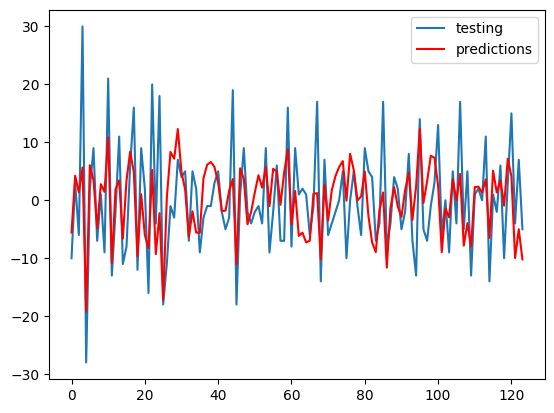

In [51]:
# plot
window = window_list[rmse_list.index(min(rmse_list))]
model = AutoReg(train, lags=window)
model_fit = model.fit()
coef = model_fit.params

# walk forward over time steps in test
history = [train[i] for i in range(len(train))]
predictions = list()
for t in range(len(test)):
    yhat = predict(coef, history)
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
rmse = sqrt(mean_squared_error(test, predictions))

print('Test RMSE: %.3f for k = %i' % (min(rmse_list), window))

plt.plot(test, label='testing')
plt.plot(predictions, color='red', label='predictions')
plt.legend()
plt.show()

## Minimum Daily Temperatures Dataset

            Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8


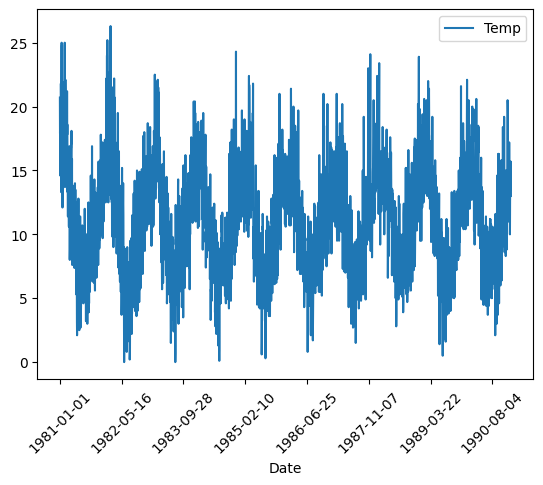

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

series = pd.read_csv('daily-min-temperatures.csv', header=0, index_col=0)
print(series.head())
series.plot()
plt.xticks(rotation=45)
plt.show()

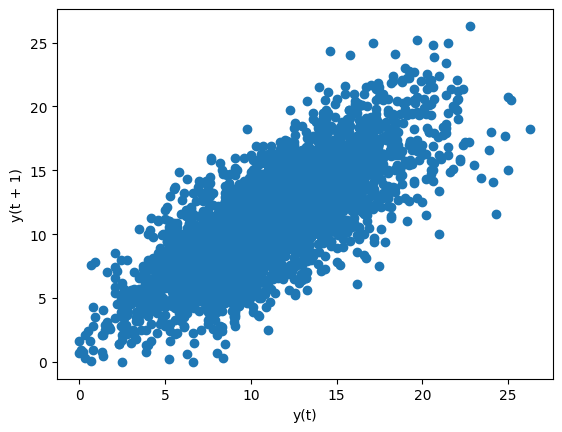

In [3]:
from pandas.plotting import lag_plot

lag_plot(series)
plt.show()

In [4]:
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

         t-1      t+1
t-1  1.00000  0.77487
t+1  0.77487  1.00000


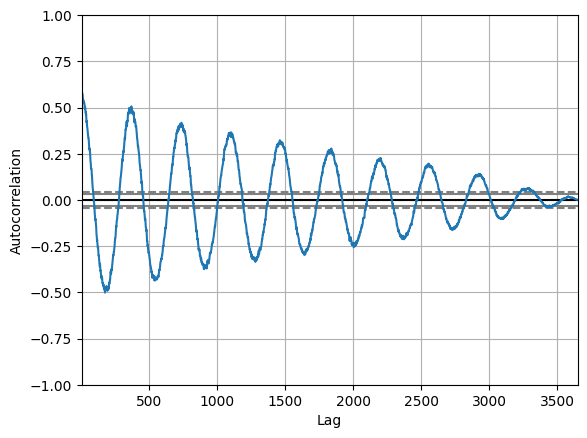

In [5]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)
plt.show()

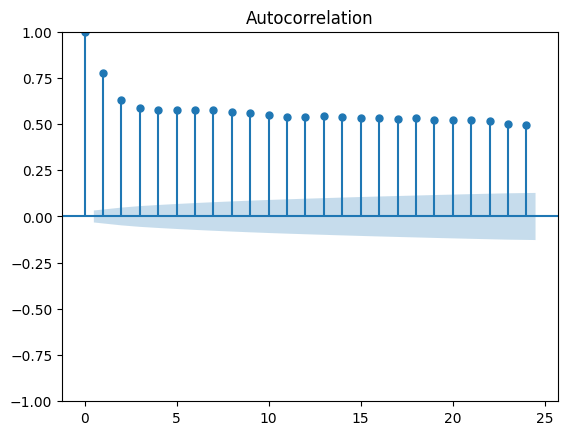

In [7]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(series, lags=24)
plt.show()

## Persistence Model

Let’s say that we want to develop a model to predict the last 7 days of minimum temperatures in the dataset given all prior observations.

The simplest model that we could use to make predictions would be to persist the last observation. We can call this a persistence model and it provides a baseline of performance for the problem that we can use for comparison with an autoregression model.

In [48]:
from sklearn.metrics import mean_squared_error

# create lagged dataset
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']

dataframe.head()

,t-1,t+1
0,NaN,20.7
1,20.7,17.9
2,17.9,18.8
3,18.8,14.6
4,14.6,15.8


In [49]:
values

,0
0,20.7
1,17.9
2,18.8
3,14.6
4,15.8
...,...
3645,14.0
3646,13.6
3647,13.5
3648,15.7


In [46]:
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:] # testing for 7 values, predictions
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [47]:
X

array([[ nan, 20.7],
       [20.7, 17.9],
       [17.9, 18.8],
       ...,
       [13.6, 13.5],
       [13.5, 15.7],
       [15.7, 13. ]])

In [15]:
train.shape, test.shape

((3642, 2), (7, 2))

In [16]:
# persistence model
def model_persistence(x):
    return x

# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
    
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)

Test MSE: 3.423


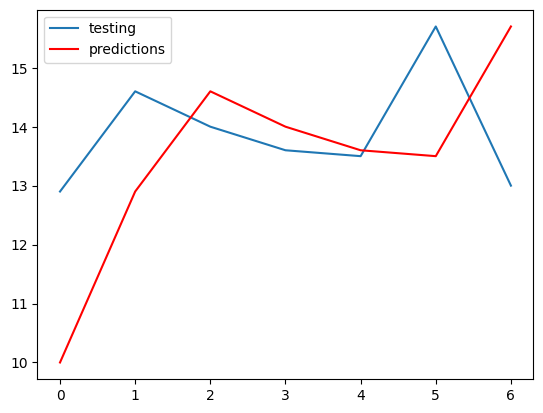

In [18]:
# plot predictions vs expected
plt.plot(test_y, label='testing')
plt.plot(predictions, color='red', label='predictions')
plt.legend()
plt.show()

## Autoregression Model
An autoregression model is a linear regression model that uses lagged variables as input variables.

We could calculate the linear regression model manually using the LinearRegession class in scikit-learn and manually specify the lag input variables to use.

Alternately, the statsmodels library provides an autoregression model where you must specify an appropriate lag value and trains a linear regression model. It is provided in the AutoReg class.

We can use this model by first creating the model AutoReg() and then calling fit() to train it on our dataset. This returns an AutoRegResults object.

Once fit, we can use the model to make a prediction by calling the predict() function for a number of observations in the future. This creates 1 7-day forecast, which is different from the persistence example above.

In [55]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

In [56]:
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]

# train autoregression
model = AutoReg(train, lags=29)
model_fit = model.fit()

In [59]:
len(train), len(test)

(3642, 7)

In [58]:
len(X)

3650

In [21]:
print('Coefficients: %s' % model_fit.params)

Coefficients: [ 5.57543506e-01  5.88595221e-01 -9.08257090e-02  4.82615092e-02
  4.00650265e-02  3.93020055e-02  2.59463738e-02  4.46675960e-02
  1.27681498e-02  3.74362239e-02 -8.11700276e-04  4.79081949e-03
  1.84731397e-02  2.68908418e-02  5.75906178e-04  2.48096415e-02
  7.40316579e-03  9.91622149e-03  3.41599123e-02 -9.11961877e-03
  2.42127561e-02  1.87870751e-02  1.21841870e-02 -1.85534575e-02
 -1.77162867e-03  1.67319894e-02  1.97615668e-02  9.83245087e-03
  6.22710723e-03 -1.37732255e-03]


In [25]:
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f, diff=%f' % (predictions[i], test[i], predictions[i]-test[i]))

predicted=11.871275, expected=12.900000, diff=-1.028725
predicted=13.053794, expected=14.600000, diff=-1.546206
predicted=13.532591, expected=14.000000, diff=-0.467409
predicted=13.243126, expected=13.600000, diff=-0.356874
predicted=13.091438, expected=13.500000, diff=-0.408562
predicted=13.146989, expected=15.700000, diff=-2.553011
predicted=13.176153, expected=13.000000, diff=0.176153


Test RMSE: 1.225


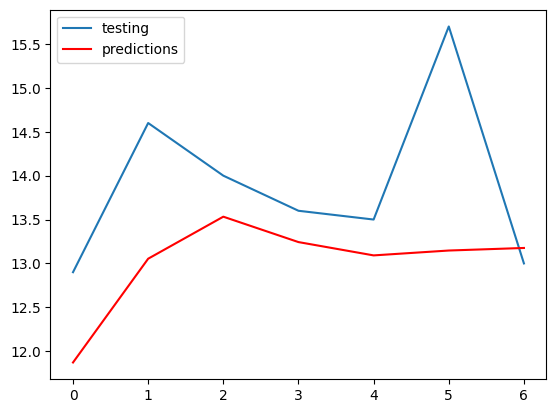

In [27]:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
plt.plot(test_y, label='testing')
plt.plot(predictions, color='red', label='predictions')
plt.legend()
plt.show()

The statsmodels API does not make it easy to update the model as new observations become available.

One way would be to re-train the AutoReg model each day as new observations become available, and that may be a valid approach, if not computationally expensive.

An alternative would be to use the learned coefficients and manually make predictions. This requires that the history of 29 prior observations be kept and that the coefficients be retrieved from the model and used in the regression equation to come up with new forecasts.

The coefficients are provided in an array with the intercept term followed by the coefficients for each lag variable starting at $t-1$ to $t-n$. We simply need to use them in the right order on the history of observations, as follows:

predicted=11.937298, expected=12.900000
predicted=13.710361, expected=14.600000
predicted=14.458722, expected=14.000000
predicted=13.493135, expected=13.600000
predicted=13.383607, expected=13.500000
predicted=13.361922, expected=15.700000
predicted=14.545455, expected=13.000000
Test RMSE: 1.184


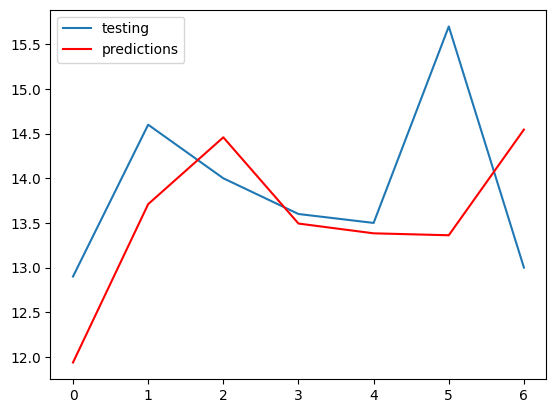

In [41]:
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]

# train autoregression
window = 24
model = AutoReg(train, lags=window)
model_fit = model.fit()
coef = model_fit.params

# walk forward over time steps in test
history = train[len(train) - window:]
history = [history[i] for i in range(len(history))]
predictions = list()

for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
        
    print('predicted=%f, expected=%f' % (yhat, obs))
    
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
plt.plot(test_y, label='testing')
plt.plot(predictions, color='red', label='predictions')
plt.legend()
plt.show()

## Implementation of k-fold cross-validation 


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit

X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSeriesSplit()

In [44]:
for train_index, test_index in tscv.split(X):
    print("Train data:", train_index, "Test data:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

Train data: [0] Test data: [1]
Train data: [0 1] Test data: [2]
Train data: [0 1 2] Test data: [3]
Train data: [0 1 2 3] Test data: [4]
Train data: [0 1 2 3 4] Test data: [5]


In [45]:
path = 'AirPassengers.csv'
data = pd.read_csv(path, index_col='Month')
print(data.shape)
data.head()

(144, 1)


,#Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


In [46]:
#divide data into train and test
train_ind = int(len(data) * 0.8)
train = data[:train_ind]
test = data[train_ind:]

In [21]:
train.shape, test.shape

((115, 1), (29, 1))

In [47]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt


model = ExponentialSmoothing(train, seasonal='mul', seasonal_periods=12, freq='MS').fit()
pred  = model.predict(start=test.index[0], end=test.index[-1])
MSE   = round(mean_squared_error(test, pred), 2)
MSE

3824.63

In [88]:
# MODELING WITH CROSS-VALIDATION
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

tscv = TimeSeriesSplit(n_splits=5)
idx_list = []

for train_index, test_index in tscv.split(data):
  # print('TRAIN:', train, '\nTEST:', test)
  print('TRAIN idx:', train_index, '\nTEST idx:', test_index) 
  print(len(train_index), len(test_index))
  idx_list.append(len(train_index))
  print('\n')
  X_train, X_test = data["#Passengers"][train_index], data["#Passengers"][test_index]
  y_train, y_test = data.index[train_index], data.index[test_index]

TRAIN idx: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] 
TEST idx: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
24 24


TRAIN idx: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] 
TEST idx: [48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
48 24


TRAIN idx: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71] 
TEST idx: [72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
72 24


TRAIN idx: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 7

In [89]:
#Splitting according to the above description
train1, test1 = data.iloc[:idx_list[0], 0], data.iloc[idx_list[0]:idx_list[1], 0]
train2, test2 = data.iloc[:idx_list[1], 0], data.iloc[idx_list[1]:idx_list[2], 0]
train3, test3 = data.iloc[:idx_list[2], 0], data.iloc[idx_list[2]:idx_list[3], 0]
train4, test4 = data.iloc[:idx_list[3], 0], data.iloc[idx_list[3]:idx_list[4], 0]
train5, test5 = data.iloc[:idx_list[4], 0], data.iloc[idx_list[4]:len(data), 0]

In [90]:
model1 = ExponentialSmoothing(train1, seasonal='mul', seasonal_periods=12).fit()
pred1  = model1.predict(start=test1.index[0], end=test1.index[-1])
MSE1   = round(mean_squared_error(test1, pred1), 2)

model2 = ExponentialSmoothing(train2, seasonal='mul', seasonal_periods=12).fit()
pred2  = model2.predict(start=test2.index[0], end=test2.index[-1])
MSE2   = round(mean_squared_error(test2, pred2), 2)

model3 = ExponentialSmoothing(train3, seasonal='mul', seasonal_periods=12).fit()
pred3  = model3.predict(start=test3.index[0], end=test3.index[-1])
MSE3   = round(mean_squared_error(test3, pred3), 2)

model4 = ExponentialSmoothing(train4, seasonal='mul', seasonal_periods=12).fit()
pred4  = model4.predict(start=test4.index[0], end=test4.index[-1])
MSE4   = round(mean_squared_error(test4, pred4), 2)

model5 = ExponentialSmoothing(train5, seasonal='mul', seasonal_periods=12).fit()
pred5  = model5.predict(start=test5.index[0], end=test5.index[-1])
MSE5   = round(mean_squared_error(test5, pred5), 2)

In [91]:
print ("MSE:", MSE)
print ("MSE1:", MSE1)
print ("MSE2:", MSE2)
print ("MSE3:", MSE3)
print ("MSE4:", MSE4)
print ("MSE5:", MSE5)

MSE: 3824.63
MSE1: 1338.84
MSE2: 635.97
MSE3: 3679.21
MSE4: 1698.86
MSE5: 6633.43


In [92]:
Overall_MSE = round((MSE1 + MSE2 + MSE3 + MSE4 + MSE5) / 5, 2)
print ("Overall MSE:", Overall_MSE) 

Overall MSE: 2797.26
